In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [116]:
from evrp.utils.utilities import *
from evrp.utils.graph import draw_plain_graph, draw_graph
from evrp.utils.plot import plot_interactive_graph
from evrp.milp.tsp import TSP
from evrp.milp.vrptw import VRPTW
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np
from scipy.spatial import distance

import pprint

import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import itertools

import networkx as nx

from pyomo.environ import *

from evrp.config.GLOBAL_CONFIG import *

pd.options.plotting.backend = "plotly"
pp = pprint.PrettyPrinter()

In [243]:
instance = 'r105c5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [187]:
del m.instance, m.results
m.instance = m.instance2.clone()
m.results = m.results2.copy()

In [190]:
# Initialize past solution
# Specify solver
opt = SolverFactory('gurobi', io_format='python')
# Solver options
solv_options = {'TimeLimit': 60*5}  # 'Symmetry': 2

# SAVE PAST MODEL RESULT
m.instance2 = m.instance.clone()
m.results2 = m.results.copy()

# CHANGE CONSTRAINTS
def constraint_energy_peak(instance, s, t):
    """Peak electric demand for each physical station s(i) ∈ S"""
    return instance.G[s, t] + sum(instance.xkappa[i, t] * instance.xp[i, t] for i in instance.Smap[s]) <= instance.xd[s]
m.instance.constraint_energy_peak = Constraint(m.instance.S, m.instance.T, rule=constraint_energy_peak)

# CHANGE OBJECTIVES
m.instance.del_component(m.instance.obj)  # Decativate the old objective
def new_obj(instance):
    return m.total_distance(instance) + m.C_fleet_capital_cost(instance) + m.cycle_cost(instance) + m.squeeze_cycle_cost(instance) + m.R_energy_arbitrage_revenue(instance) + m.R_peak_shaving_revenue(instance)
m.instance.obj = Objective(rule=new_obj, sense=minimize)

# Solve instance
m.results = opt.solve(m.instance, tee=True, warmstart=True, options=solv_options)

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmp2r_5_0fa.pyomo.lp
Reading time = 0.05 seconds
: 2186 rows, 1414 columns, 4894 nonzeros
Read MIP start from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpjzn5epg2.gurobi.mst
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2186 rows, 1414 columns and 4894 nonzeros
Model fingerprint: 0x4557f771
Model has 1350 quadratic objective terms
Model has 4503 quadratic constraints
Variable types: 736 continuous, 678 integer (678 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [9e-02, 2e+03]
  QOb

In [191]:
print(m.results)


Problem: 
- Name: 
  Lower bound: 2525.1082639838332
  Upper bound: 2525.1648193067313
  Number of objectives: 1
  Number of constraints: 6689
  Number of variables: 1414
  Number of binary variables: 678
  Number of integer variables: 678
  Number of continuous variables: 736
  Number of nonzeros: 4894
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.32448506355285645
  Error rc: 0
  Time: 0.6872642040252686
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [100]:
# Testing if instatiating and running same model improves results

# SAVE PAST MODEL RESULT
m.instance3 = m.instance.clone()
m.results3 = m.results.copy()

m.results3_ = opt.solve(m.instance, tee=True, warmstart=True, options=solv_options)

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmp_u57l7nd.pyomo.lp
Reading time = 0.08 seconds
x1687: 734 rows, 1684 columns, 2690 nonzeros
Read MIP start from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpvpz49edy.gurobi.mst
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 734 rows, 1684 columns and 2690 nonzeros
Model fingerprint: 0x2cf31dec
Model has 12198 quadratic objective terms
Model has 5616 quadratic constraints
Variable types: 733 continuous, 951 integer (951 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 3e+03]
  Objective range  [3e+00, 1e+03]
 

2021-01-26 02:14:19 WARNING  Loading a SolverResults object with an 'aborted' status, but containing a solution


    containing a solution


In [279]:
print(m.results3_)

AttributeError: 'EVRPTW' object has no attribute 'results3_'

In [477]:
test = 'Minimize OpEx CapEx Cycle EA DCM FullStart=End Noxkappabounds'
test.lower().split()
test

'Minimize OpEx CapEx Cycle EA DCM FullStart=End Noxkappabounds'

In [491]:
m = EVRPTW(problem_type='Minimize OpEx CapEx Cycle EA DCM FullStart=End')
m.full_solve(fpath)

2021-02-04 03:10:46 INFO     Building abstract model
2021-02-04 03:10:46 INFO     Defining parameters and sets
2021-02-04 03:10:46 INFO     Defining variables
2021-02-04 03:10:46 INFO     Defining constraints
2021-02-04 03:10:46 INFO     Importing EVRPTW MILP instance: r105c5_e
2021-02-04 03:10:46 INFO     Reading CSV
2021-02-04 03:10:46 INFO     Creating graph
2021-02-04 03:10:46 INFO     Creating timeseries data
2021-02-04 03:10:46 INFO     Creating duplicates and extended graph
2021-02-04 03:10:46 INFO     Calculating distance matrix
2021-02-04 03:10:46 INFO     Creating parameters
2021-02-04 03:10:46 INFO     Creating instance
2021-02-04 03:10:46 INFO     Problem type: Minimize OpEx CapEx Cycle EA DCM FullStart=End
2021-02-04 03:10:46 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpvtdaw8ic.pyomo.lp
Reading time = 0.01 seconds
: 346 rows, 452 columns, 1197 nonzeros
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 346 rows, 452 columns and 1197 nonzeros
Model fingerprint: 0xc20408d8
Model has 1788 quadratic objective terms
Model has 1305 quadratic constraints
Variable types: 181 continuous, 271 integer (271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [1e+00, 3e+02]
  Objective range  [9e+00, 1e+03]
  QObjective range [6e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  QR

2021-02-04 03:10:51 INFO     Done


In [492]:
print(m.results)


Problem: 
- Name: 
  Lower bound: 2317.050321359793
  Upper bound: 2317.050321359793
  Number of objectives: 1
  Number of constraints: 1651
  Number of variables: 452
  Number of binary variables: 271
  Number of integer variables: 271
  Number of continuous variables: 181
  Number of nonzeros: 1197
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 4.253671169281006
  Error rc: 0
  Time: 4.36673903465271
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [493]:
var_list = ['xkappa', 'xp']
xp = merge_variable_results(m, var_list)

In [494]:
xp = xp[xp['state']>1e-4].sort_values(['t'], ascending=True)
# print(xp.to_string())
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,630,3.0,4.482863
S0_1,630,3.0,4.636151
S0_2,60,3.0,-0.282845
S0_3,90,3.0,-4.152503
S13_0,240,3.0,6.063000
S1_0,360,3.0,6.063000


In [495]:
var_list = ['xgamma', 'xw', 'xq', 'xa']
x = merge_variable_results(m, var_list)

In [496]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa
34,D0,S0_2,1.0,0.000000,21.0,60.630000
45,D0,S0_3,1.0,0.000000,37.0,60.630000
103,S0_2,C75,1.0,67.784888,21.0,30.016662
71,S0_3,S13_0,1.0,70.000000,37.0,0.000000
84,S13_0,C91,1.0,107.000000,37.0,53.921796
64,C75,S1_0,1.0,108.000000,3.0,0.000000
129,C91,C95,1.0,130.000000,36.0,42.741456
116,S1_0,C78,1.0,158.935551,3.0,45.332941
99,C95,C28,1.0,183.675445,16.0,22.125928
19,C28,S0_0,1.0,200.000000,0.0,15.801373


In [497]:
test = x[x['state']>1e-4].sort_values(['xw'])
route = zip(test['from'], test['to'])
sum([m.data['d'].loc[fr, to] for fr, to in route])

168.09665813626955

In [498]:
e, e_flat = create_optimal_edges(m, x=x, graph='V_')

In [499]:
plot_interactive_graph(m.data['V'], e=e_flat, obj=m.instance.obj(), instance_name=m.instance_name)

In [500]:
traces = trace_routes(m)

In [501]:
routes = x[x['state']>1e-4].sort_values(['xw']).set_index(['from', 'to'])

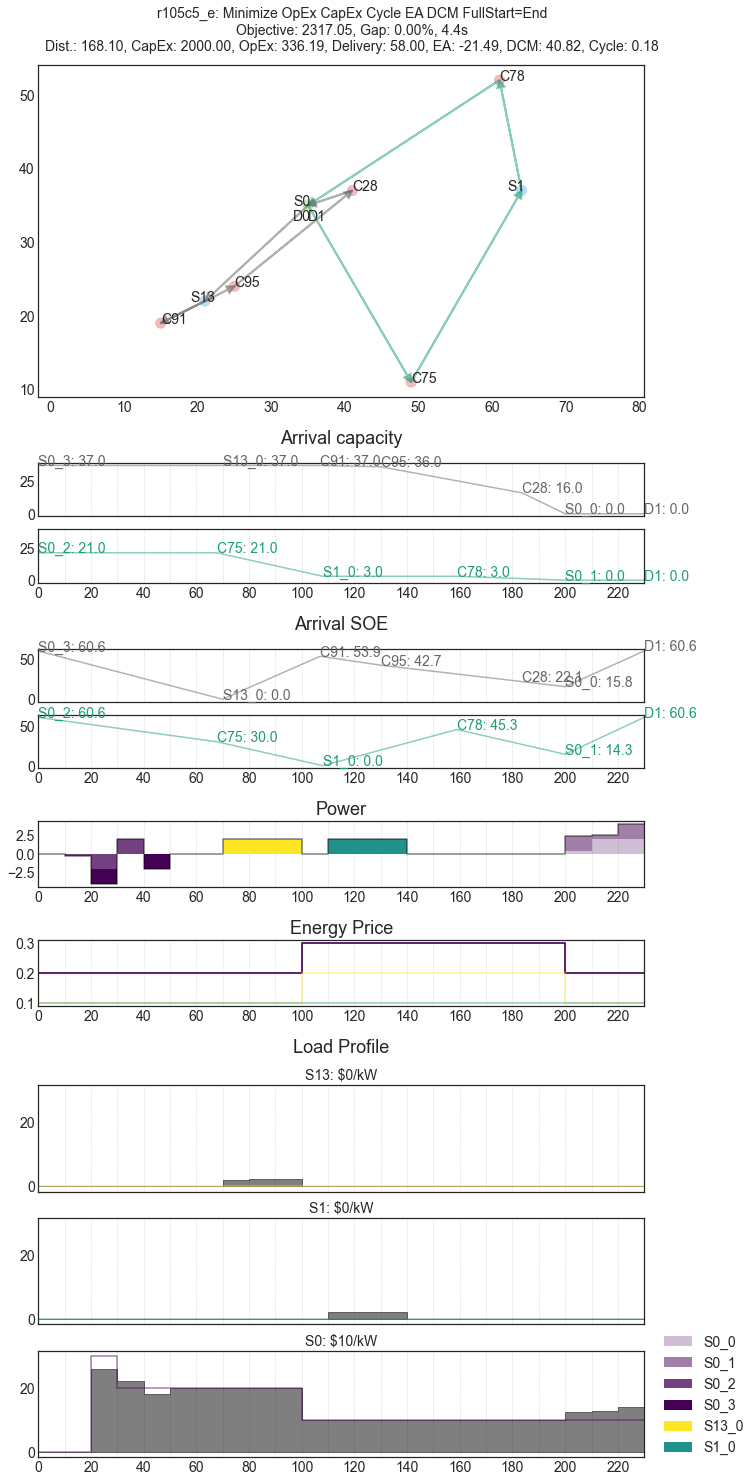

In [504]:
n_plots = 6
style_label = u'seaborn-white'

t_S = m.data['Parameters'].loc['t_S', 'value']
t_T = m.data['Parameters'].loc['t_T', 'value']
time = np.arange(0, t_T, t_S)
t_major = (t_T / 10 - (t_T / 10) % t_S)

nt = len(traces)  # number of vehicles
stations = np.sort(xp['node'].unique())  # stations
ns = len(stations)
unique_stations = np.unique([m.s_2s[s] for s in stations])
nus = len(unique_stations)

gap = m.results['Problem'][0]
gap = round((gap['Upper bound'] - gap['Lower bound']) / gap['Upper bound'] * 100, 2)

# Load Profiles
# G = m.data['G'].copy()
G = pd.Series(m.instance.G.extract_values())
G = G.reset_index().pivot(index='level_1', columns='level_0', values=0)

# Energy Price
ce = pd.Series(m.instance.ce.extract_values())
ce = ce.reset_index().pivot(index='level_1', columns='level_0', values=0)
# ce = m.data['ce']

# Get colors for each vehicle
c = plt.get_cmap('Dark2')
colors = [c(tc) for tc in np.linspace(0, 1, len(traces))]

# Get colors for each station
c2 = plt.get_cmap('viridis')
colors2 = [c2(tc) for tc in np.linspace(0, 1, nus)]
us_color = {s: colors2[i] for i, s in enumerate(unique_stations)}
s_color = {s_: us_color[m.s_2s[s_]] for s_ in stations}
s_alpha = {s: 0 for s in unique_stations}
for s_, c in s_color.items():
    s = m.s_2s[s_]
    s_alpha[s] += 1/m.data['S']['instances'][s]
    c = list(c)
    c[-1] = s_alpha[s]
    s_color[s_] = tuple(c)

# fig, axs = plt.subplots(n_plots-1, 2, figsize=(10,10), sharex='col', 
#                         gridspec_kw={'width_ratios': [2, 1], 'height_ratios': [1, 1, 1, 1]})

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fweight = 2  # title fontweights
fdict = {'fontsize': MEDIUM_SIZE, 'fontweight' : fweight}  # subplot titles

plt.style.use(style_label)
fig = plt.figure(figsize=(10,20), num=style_label)

gs = GridSpec(n_plots, 1, width_ratios=[1], height_ratios=[n_plots-1, nt, nt, 1, 1, ns])
axs0 = fig.add_subplot(gs[0, 0])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[2, 0], sharex=axs1)
axs3 = fig.add_subplot(gs[3, 0], sharex=axs1)
axs4 = fig.add_subplot(gs[4, 0], sharex=axs1)
axs5 = fig.add_subplot(gs[5, 0], sharex=axs1)

obj_breakdown = [m.total_distance(m.instance)(),
                 m.C_fleet_capital_cost(m.instance)(),
                 m.O_delivery_operating_cost(m.instance)() + m.O_maintenance_operating_cost(m.instance)(),
                 m.R_delivery_revenue(m.instance)(),
                 m.R_energy_arbitrage_revenue(m.instance)(), 
                 m.R_peak_shaving_revenue(m.instance)(), # - sum(G.max()[s] * cg for s, cg in m.instance.cg.extract_values().items()),
                 m.cycle_cost(m.instance)() + m.squeeze_cycle_cost(m.instance)()]

title = ''
title += '{}: {}\n'.format(m.instance_name, m.problem_type)
title += 'Objective: {:.2f}, Gap: {:.2f}%, {:.1f}s\n'.format(m.instance.obj.expr(), gap, m.results['Solver'][0]['Time'])
title += 'Dist.: {:.2f}, CapEx: {:.2f}, OpEx: {:.2f}, Delivery: {:.2f}, EA: {:.2f}, DCM: {:.2f}, Cycle: {:.2f}'.format(*obj_breakdown)
fig.suptitle(title, x=0.5, y=1.03, horizontalalignment='center', verticalalignment='top', size=SMALL_SIZE, weight=fweight)

a = 0.5

for i, n in enumerate('SDM'):
    # Plot the nodes
    axs0.scatter(m.data[n]['d_x'], m.data[n]['d_y'], c=[node_colors_rgba_tuple[n]]*len(m.data[n]), s=100)

    # Annotate the nodes
    for j, txt in enumerate(m.data[n].index):
        scale = 2
        if n == 'D':
            offset = [-scale, -scale]
        elif n == 'S':
            offset = [-scale, 0]
        else:
            offset = [0, 0]
        if txt == 'D1':
            offset = [0, -scale]
            
        axs0.annotate(txt, (m.data[n]['d_x'][j]+offset[0], m.data[n]['d_y'][j]+offset[1]))

# Plot the vehicle routes    
for ti, t in enumerate(traces):
    for ki, k in enumerate(t[:-1]):
        arrow_x = m.data['V_'].loc[t[ki], 'd_x']
        arrow_y = m.data['V_'].loc[t[ki], 'd_y']
        arrow_dx = m.data['V_'].loc[t[ki+1], 'd_x'] - arrow_x
        arrow_dy = m.data['V_'].loc[t[ki+1], 'd_y'] - arrow_y
        
        axs0.arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, alpha=a, linewidth=2,
                     length_includes_head=True, head_width=1, head_length=1, overhang=0, color=colors[ti])
    
    axs0.set_aspect('equal', adjustable='datalim')
    
    # Plot the vehicle states
    r = routes.loc[list(zip(t[:-1], t[1:]))]
    
    # Plot arrival capacity
    # create an inset axe in the current axe:
    ax1 = axs1.inset_axes([0, ti*1/nt, 1, .8*1/nt])
    ax1.plot(r['xw'], r['xq'], color=colors[ti], alpha=a) 
    for row in r.iterrows():
        ax1.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xq']), xy=(row[1]['xw'], row[1]['xq']), color=colors[ti])
    ax1.get_shared_x_axes().join(ax1, axs1)
    ax1.get_shared_y_axes().join(ax1, axs1)
    ax1.set_xticklabels([])
    ax1.xaxis.set_major_locator(MultipleLocator(t_major))
    ax1.xaxis.set_minor_locator(MultipleLocator(t_S))
    ax1.grid(True, which='both', axis='x', alpha=5, linestyle=':')
    axs1.set_yticklabels([])
    axs1.set_xlim([0, t_T])
#     axs1.axis('off')
#     axs1.get_xaxis().set_visible(True)
#     axs1.grid(False)
    axs1.spines['right'].set_visible(False)
    axs1.spines['top'].set_visible(False)
    axs1.spines['bottom'].set_visible(False)
    axs1.spines['left'].set_visible(False)
    axs1.set_title('Arrival capacity', fontdict=fdict)   
    
    # Plot arrival SOE
    # create an inset axe in the current axe:
    ax2 = axs2.inset_axes([0, ti*1/nt, 1, .8*1/nt])
    ax2.plot(r['xw'], r['xa'], color=colors[ti], alpha=a)
    for row in r.iterrows():
        ax2.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xa']), xy=(row[1]['xw'], row[1]['xa']), color=colors[ti])
    ax2.get_shared_x_axes().join(ax2, axs2)
    ax2.get_shared_y_axes().join(ax2, axs2)
    ax2.set_xticklabels([])
    ax2.xaxis.set_major_locator(MultipleLocator(t_major))
    ax2.xaxis.set_minor_locator(MultipleLocator(t_S))
    ax2.grid(True, which='both', axis='x', alpha=5, linestyle=':')
    axs2.set_yticklabels([])
    axs2.set_xlim([0, t_T])
    axs2.spines['right'].set_visible(False)
    axs2.spines['top'].set_visible(False)
    axs2.spines['bottom'].set_visible(False)
    axs2.spines['left'].set_visible(False)
    axs2.set_title('Arrival SOE', fontdict=fdict)
    
# Plot power
s = stations[0]
bott = pd.DataFrame(index=time)
bott['xp'] = 0
ind = xp[xp['node']==s]['t']
axs3.bar(ind, xp[xp['node']==s]['xp'], 
         label=s, width=t_S, align='edge', color=s_color[s])
for s2 in stations[1:]:
    ind = xp[xp['node']==s]['t']
    bott['xp'].loc[ind] += xp[xp['node']==s]['xp'].values
    axs3.bar(xp[xp['node']==s2]['t'], xp[xp['node']==s2]['xp'], bottom=bott.loc[xp[xp['node']==s2]['t']].values.reshape(-1),
             label=s2, width=t_S, align='edge', color=s_color[s2])
    s = s2
ind = xp[xp['node']==s]['t']
bott['xp'].loc[ind] += xp[xp['node']==s]['xp'].values

# axs3.hlines(bott['xp'], bott.index, bott.index+t_S)
bott.loc[t_T, 'xp'] = bott.loc[t_T-t_S, 'xp']
axs3.step(bott.index, bott['xp'], where='post', alpha=a, color='black')
axs3.set_title('Power', fontdict=fdict)

axs3.xaxis.set_major_locator(MultipleLocator(t_major))
axs3.xaxis.set_minor_locator(MultipleLocator(t_S))
axs3.grid(True, which='both', axis='x', alpha=5, linestyle=':')
# axs3.legend(loc="upper left", ncol=round(ns/2), bbox_to_anchor=(0, -.25));

# Plot energy price
ce.loc[t_T] = ce.loc[t_T-t_S]
for s in stations:
    axs4.step(ce[m.s_2s[s]].index, ce[m.s_2s[s]], where='post', label='_nolegend_', alpha=a, color=s_color[s])
axs4.set_title('Energy Price', fontdict={'fontsize': MEDIUM_SIZE, 'fontweight' : fweight})  

axs4.xaxis.set_major_locator(MultipleLocator(t_major))
axs4.xaxis.set_minor_locator(MultipleLocator(t_S))
axs4.grid(True, which='both', axis='x', alpha=5, linestyle=':')

# Plot load profiles
G.loc[t_T] = G.loc[t_T-t_S]

# calculate total power for each station
temp = xp.copy()
temp['s'] = temp['node'].apply(lambda x: m.s_2s[x])
total_power = temp.groupby(['s', 't']).sum()

for si, s in enumerate(unique_stations):
    # create an inset axe in the current axe:
    ax5 = axs5.inset_axes([0, si*1/nus, 1, .8*1/nus])
    ax5.step(G[s].index, G[s], where='post', label='_nolegend_', alpha=a, color=us_color[s])
    
    net_load = G[s].copy()
    net_load[total_power.loc[s].index] += total_power.loc[s]['xp']
    ax5.fill_between(net_load.index, net_load, step="post", alpha=a, color='black')
    
    ax5.get_shared_x_axes().join(ax5, axs5)
    ax5.get_shared_y_axes().join(ax5, axs5)
    ax5.set_xticklabels([])
    axs5.set_yticklabels([])
    axs5.set_xlim([0, t_T])
    ax5.title.set_text('{}: ${}/kW'.format(s, m.data['S'].loc[s, 'cg']))  
    
    ax5.xaxis.set_major_locator(MultipleLocator(t_major))
    ax5.xaxis.set_minor_locator(MultipleLocator(t_S))
    ax5.grid(True, which='both', axis='x', alpha=5, linestyle=':')

axs5.spines['right'].set_visible(False)
axs5.spines['top'].set_visible(False)
axs5.spines['bottom'].set_visible(False)
axs5.spines['left'].set_visible(False)
axs5.set_title('Load Profile', fontdict=fdict)  

fig.legend(loc="lower right", bbox_to_anchor=(1.05, 0.01)); # ncol=round(nus), , bbox_to_anchor=(1.05, .4)

fig.tight_layout()

In [292]:
xp

,node,t,state,xp
70,S0_3,10,1.0,2.040816
101,S1_0,90,1.0,1.981367
102,S1_0,100,1.0,2.040816
105,S1_0,130,1.0,2.040816


In [293]:
routes

,,state,xw,xq,xa,from_d_x,from_d_y,to_d_x,to_d_y
from,to,,,,,,,,
D0,S0_0,1.0,0.000000,37.0,37.393387,35,35,35,35
S0_0,S0_3,1.0,0.000000,37.0,37.393387,35,35,35,35
S0_3,C75,1.0,49.000000,37.0,30.016662,35,35,49,11
D0,C91,1.0,77.000000,21.0,26.046409,35,35,15,19
C75,S1_0,1.0,89.016662,19.0,0.000000,49,11,64,37
C91,C95,1.0,130.000000,20.0,14.866069,15,19,25,24
C95,S0_2,1.0,154.866069,0.0,0.000000,25,24,35,35
S1_0,C78,1.0,158.000000,19.0,31.324555,64,37,61,52
C78,C28,1.0,193.000000,16.0,6.324555,61,52,41,37


In [294]:
i = 'S0_2'
j = 'D1'
m.instance.xw[i]() + m.instance.d[i, j] + m.instance.t_S() * sum(m.instance.xkappa[i, t] for t in m.instance.T)() - m.instance.xw[j]()

-75.13393125268149

In [ ]:
m.data['d']

In [ ]:
routes

In [1383]:
m.instance.obj.expr()

2426.4937076977776

In [1384]:
sum(sum(sum(m.instance.ce.extract_values()[(s,t)] * m.instance.xp.extract_values()[(i,t)] * m.instance.xkappa.extract_values()[(i,t)] for t in m.instance.T.data()) for i in m.instance.Smap.extract_values()[s]) for s in m.instance.S.data())

1.096728461629606

In [1385]:
xp.groupby('node').describe()

t                                                      state       \
      count   mean        std    min    25%    50%    75%    max count mean   
node                                                                          
S0_0    3.0   30.0  10.000000   20.0   25.0   30.0   35.0   40.0   3.0  1.0   
S0_1    5.0   20.0  15.811388    0.0   10.0   20.0   30.0   40.0   5.0  1.0   
S0_2    1.0  220.0        NaN  220.0  220.0  220.0  220.0  220.0   1.0  1.0   
S0_3    7.0  190.0  21.602469  160.0  175.0  190.0  205.0  220.0   7.0  1.0   
S13_0   3.0   80.0  10.000000   70.0   75.0   80.0   85.0   90.0   3.0  1.0   
S1_0    3.0  130.0  10.000000  120.0  125.0  130.0  135.0  140.0   3.0  1.0   

       ...              xp                                                    \
       ...  75%  max count      mean       std       min       25%       50%   
node   ...                                                                     
S0_0   ...  1.0  1.0   3.0  0.636832  2.319827 -2.040816 -0.065160  1.910497   
S0_1   ...  1.0  1.0   5.0  1.156031  1.793228 -2.040816  1.698522  2.040816   
S0_2   ...  1.0  1.0   1.0 -1.400839       NaN -1.400839 -1.400839 -1.400839   
S0_3   ...  1.0  1.0   7.0 -0.398220  2.063743 -2.040816 -2.040816 -2.040816   
S13_0  ...  1.0  1.0   3.0  2.021000  0.034323  1.981367  2.011092  2.040816   
S1_0   ...  1.0  1.0   3.0  2.021000  0.017161  2.011092  2.011092  2.011092   

                           
            75%       max  
node                       
S0_0   1.975657  2.040816  
S0_1   2.040816  2.040816  
S0_2  -1.400839 -1.400839  
S0_3   1.667455  2.040816  
S13_0  2.040816  2.040816  
S1_0   2.025954  2.040816  

[6 rows x 24 columns]

In [776]:
test = [xp.set_index('node').loc[n,'state'] * v for n, v in routes.reset_index('to')['state'].iteritems() if n in xp['node'].unique()]

In [182]:
m.instance2.xgamma.free()

In [184]:
m.instance2.xgamma.fix()

In [229]:
m.instance2.xkappa.get_values()

{('S0_0', 0): 0.0,
 ('S0_0', 30): 0.0,
 ('S0_0', 60): 0.0,
 ('S0_0', 90): 0.0,
 ('S0_0', 120): 0.0,
 ('S0_0', 150): 0.0,
 ('S0_0', 180): 0.0,
 ('S0_0', 210): 0.0,
 ('S0_0', 240): 0.0,
 ('S0_0', 270): 0.0,
 ('S0_0', 300): 0.0,
 ('S0_0', 330): 0.0,
 ('S0_0', 360): 0.0,
 ('S0_0', 390): 0.0,
 ('S0_0', 420): 0.0,
 ('S0_0', 450): 0.0,
 ('S0_0', 480): 0.0,
 ('S0_0', 510): 0.0,
 ('S0_0', 540): 0.0,
 ('S0_0', 570): 0.0,
 ('S0_0', 600): 0.0,
 ('S0_0', 630): 0.0,
 ('S0_0', 660): 0.0,
 ('S0_0', 690): 0.0,
 ('S0_0', 720): 0.0,
 ('S0_0', 750): 0.0,
 ('S0_0', 780): 0.0,
 ('S0_0', 810): 0.0,
 ('S0_0', 840): 0.0,
 ('S0_0', 870): 0.0,
 ('S0_0', 900): 0.0,
 ('S0_0', 930): 0.0,
 ('S0_0', 960): 0.0,
 ('S0_0', 990): 0.0,
 ('S0_0', 1020): 0.0,
 ('S0_0', 1050): 0.0,
 ('S0_0', 1080): 0.0,
 ('S0_0', 1110): 0.0,
 ('S0_0', 1140): 0.0,
 ('S0_0', 1170): 0.0,
 ('S0_0', 1200): 0.0,
 ('S0_0', 1230): 0.0,
 ('S0_0', 1260): 0.0,
 ('S0_0', 1290): 0.0,
 ('S0_0', 1320): 0.0,
 ('S0_0', 1350): 0.0,
 ('S0_0', 1380): 0.0,
 ('S0

In [263]:
m.instance.GMAX.display()

GMAX : Maximum station electric demand
    Size=3, Index=S, Domain=Any, Default=None, Mutable=True
    Key : Value
     S0 :    30
     S1 :     0
    S13 :     0
